In [1]:
import torch

In [2]:
import pandas as pd

In [3]:
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np 
import os
from tqdm import tqdm

In [4]:
import torch.nn.functional as F 
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TransformerConv, TopKPooling 
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
# torch.manual_seed(42)

In [5]:
import mlflow.pytorch

In [6]:
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

Torch version: 1.11.0
Cuda available: True
Torch geometric version: 2.0.4


## Dataset Creation

https://github.com/quarkslab/dataset-call-graph-blogpost-material

https://colab.research.google.com/drive/17JFlnMUjcsMmXQYXF8xZ3z169VDAwUls?authuser=1

https://www.youtube.com/watch?v=QLIkOtKS4os&list=PLV8yxwGOxvvoNkzPfCx2i8an--Tkt7O8Z&index=9

In [7]:
# test_dataset = MoleculeDataset(root="data/", filename="HIV_test.csv", test=True)

In [8]:
import pickle
path_temp= "dataset-call-graph-blogpost-material/dataset/"

In [9]:
good_data=pickle.load(open(path_temp+"goodware_graphs.p","rb"))
bad_data=pickle.load(open(path_temp+"malware_graphs.p","rb"))

In [10]:
print("length of array = ",len(good_data))
print("length of 1 item = ",len(good_data[0]))
print("length of first thing in one item = ",len(good_data[0][0]))
print("length of second thing in one item = ",len(good_data[0][1]))

length of array =  546
length of 1 item =  2
length of first thing in one item =  464
length of second thing in one item =  464


In [11]:
node_feature_menu=['mov', 'call', 'lea', 'jmp', 'push', 'add', 'xor', 'cmp', 'int3', 'nop', 'pushl', 'dec', 'sub', 'insl', 'inc','jz', 'jnz', 'je', 'jne', 'ja', 'jna', 'js', 'jns', 'jl', 'jnl', 'jg', 'jng']

In [50]:

class MoleculeDataset(Dataset):
    def __init__(self, root, filename,good_data, bad_data, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        self.good_data=good_data
        self.bad_data=bad_data
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        self.data_passed=self.good_data+self.bad_data
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return ["goodware_graphs.p","malware_graphs.p"]

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
#         self.data = self.data_passed
        return "NOt implemented yet"

        # if self.test:
        #     return [f'data_test_{i}.pt' for i in list(self.data.index)]
        # else:
        #     return [f'data_{i}.pt' for i in list(self.data.index)]

    def download(self):
        pass

    def process(self):
#         self.data = self.data_passed
        print("started doing stuff")
        index=0

        for mol in (self.good_data):
            

            feature_data=mol[0]
            neighbour_data=mol[1]

            # i need to create inst ->index
            instr_index=dict()
            for a,b in enumerate(feature_data):
              instr_index[b]=a 

            # Get node features
            node_feats = self._get_node_features(feature_data,instr_index)
            # Get edge features
            edge_feats = self._get_edge_features(neighbour_data)
#             edge_feats = []
            # Get adjacency info
            edge_index = self._get_adjacency_info(neighbour_data,instr_index)

            # Get labels info
            label = 1

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol
                        ) 
                        
            torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

            index+=1
        
        for mol in (self.bad_data):
            

            feature_data=mol[0]
            neighbour_data=mol[1]

            # i need to create inst ->index
            instr_index=dict()
            for a,b in enumerate(feature_data):
              instr_index[b]=a 

            # Get node features
            node_feats = self._get_node_features(feature_data,instr_index)
            # Get edge features
            edge_feats = self._get_edge_features(neighbour_data)
#             edge_feats = []
            # Get adjacency info
            edge_index = self._get_adjacency_info(neighbour_data,instr_index)

            # Get labels info
            label = 0

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol
                        ) 
                        
            torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

            index+=1
        
        

    def process_node_features(self,val, node_feature_menu):
      # print("jj")
      # print(val)
      node_out=[]
      keys=val.keys()
      for name in node_feature_menu : 
        if(name in keys):
          node_out.append(val[name])
        else:
          node_out.append(0)
      return node_out


    def _get_node_features(self, node_features,instr_index):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        node_feature_menu=['mov', 'call', 'lea', 'jmp', 'push', 'add', 'xor', 'cmp', 'int3', 'nop', 'pushl', 'dec', 'sub', 'insl', 'inc','jz', 'jnz', 'je', 'jne', 'ja', 'jna', 'js', 'jns', 'jl', 'jnl', 'jg', 'jng']

        all_node_feats = []

        for atom in node_features:
            # print("atom is",atom)
            
            node_feats = []
            node_feats = self.process_node_features(node_features[atom],node_feature_menu)
            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        # for bond in mol.GetBonds():
        #     edge_feats = []
        #     # Feature 1: Bond type (as double)
        #     edge_feats.append(bond.GetBondTypeAsDouble())
        #     # Feature 2: Rings
        #     edge_feats.append(bond.IsInRing())
        #     # Append node features to matrix (twice, per direction)
        #     all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def get_one_instr_adjacency(self,val,instr_index,self_instruction_number):
        edge_val=[]
        for a in val:
            edge_val+=[[instr_index[self_instruction_number],instr_index[a]]]

        return edge_val

    def _get_adjacency_info(self, mol, instr_index):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        edge_indices = []
        for bond in mol:
            edge_indices += self.get_one_instr_adjacency(mol[bond],instr_index,bond)

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
#         return self.data_pass.shape[0]
        return len(self.data_passed)

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        data = torch.load(os.path.join(self.processed_dir, 
                             f'data_{idx}.pt'))
        return data





In [13]:
train_dataset = MoleculeDataset(root="data/", filename="goodware_graphs.p", good_data=good_data, bad_data=bad_data)

Processing...


started doing stuff


Done!


## MODEL

In [76]:
import torch
import torch.nn.functional as F 
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import TransformerConv, GATConv, TopKPooling, BatchNorm
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn.conv.x_conv import XConv
torch.manual_seed(42)

class GNN(torch.nn.Module):
    def __init__(self, feature_size):
        super(GNN, self).__init__()
        num_classes = 2
        embedding_size = 28

        # GNN layers
        self.conv1 = GATConv(feature_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform1 = Linear(embedding_size*3, embedding_size)
        self.pool1 = TopKPooling(embedding_size, ratio=0.8)
        self.conv2 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform2 = Linear(embedding_size*3, embedding_size)
        self.pool2 = TopKPooling(embedding_size, ratio=0.5)
        self.conv3 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform3 = Linear(embedding_size*3, embedding_size)
        self.pool3 = TopKPooling(embedding_size, ratio=0.2)

        # Linear layers
        self.linear1 = Linear(embedding_size*2, 1024)
        self.linear2 = Linear(1024, num_classes)  

    def forward(self, x, edge_attr, edge_index, batch_index):
        # First block
        # print("in in conv1",x)
        x = self.conv1(x, edge_index)
        # print("out in conv1",x)
        x = self.head_transform1(x)

        x, edge_index, edge_attr, batch_index, _, _ = self.pool1(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x1 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Second block
        x = self.conv2(x, edge_index)
        x = self.head_transform2(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool2(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x2 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Third block
        x = self.conv3(x, edge_index)
        x = self.head_transform3(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool3(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x3 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Concat pooled vectors
        x = x1 + x2 + x3

        # Output block
        x = self.linear1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear2(x)

        return x


In [77]:
import torch 
from torch_geometric.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
from tqdm import tqdm
# from dataset_featurizer import MoleculeDataset
# from model import GNN
import mlflow.pytorch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)





In [78]:
#%% Loading the model
model = GNN(feature_size=train_dataset[0].x.shape[1]) 
model = model.to(device)
print(f"Number of parameters: {count_parameters(model)}")
model

Number of parameters: 75370


GNN(
  (conv1): GATConv(27, 28, heads=3)
  (head_transform1): Linear(in_features=84, out_features=28, bias=True)
  (pool1): TopKPooling(28, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(28, 28, heads=3)
  (head_transform2): Linear(in_features=84, out_features=28, bias=True)
  (pool2): TopKPooling(28, ratio=0.5, multiplier=1.0)
  (conv3): GATConv(28, 28, heads=3)
  (head_transform3): Linear(in_features=84, out_features=28, bias=True)
  (pool3): TopKPooling(28, ratio=0.2, multiplier=1.0)
  (linear1): Linear(in_features=56, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=2, bias=True)
)

In [79]:
#%% Loss and Optimizer
# original
weights = torch.tensor([1, 1], dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)  
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)


In [80]:
optimizer.zero_grad()        
clip_value=5
torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
optimizer.step()

In [81]:
#%% Prepare training
# NUM_GRAPHS_PER_BATCH = 256
NUM_GRAPHS_PER_BATCH = 100

train_loader = DataLoader(train_dataset, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True,
                         num_workers=0)
# test_loader = DataLoader(test_dataset, 
#                          batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(train_dataset, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)


D:\Anaconda3\envs\pytorch\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [82]:
def test(epoch):
    all_preds = []
    all_labels = []
    for batch in test_loader:
        batch.to(device)  
        pred = model(batch.x.float(), 
                        batch.edge_attr.float(),
                        batch.edge_index, 
                        batch.batch) 
        loss = torch.sqrt(loss_fn(pred, batch.y))    
        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(batch.y.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "test")
    return loss


def calculate_metrics(y_pred, y_true, epoch, type):
    print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
    print(f"F1 Score: {f1_score(y_pred, y_true)}")
    print(f"Accuracy: {accuracy_score(y_pred, y_true)}")
    print(f"Precision: {precision_score(y_pred, y_true)}")
    print(f"Recall: {recall_score(y_pred, y_true)}")
    try:
        roc = roc_auc_score(y_pred, y_true)
        print(f"ROC AUC: {roc}")
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(roc), step=epoch)
    except:
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(0), step=epoch)
        print(f"ROC AUC: notdefined")
        
    try:
        mlflow.log_metric(key=f"accuracy-{type}", value=float(accuracy_score(y_pred, y_true)), step=epoch)
    except:
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(0), step=epoch)
        print(f"Accuracy: notdefined")

In [83]:

def train(epoch):
    # Enumerate over the data
    all_preds = []
    all_labels = []
    for _, batch in enumerate(tqdm(train_loader)):
        # Use GPU
        batch.to(device)  
        # Reset gradients

        optimizer.zero_grad() 
        # Passing the node features and the connection info
        pred = model(batch.x.float(), 
                                batch.edge_attr.float(),
                                batch.edge_index, 
                                batch.batch) 
        loss_v1 = loss_fn(pred, batch.y) 
        loss_v2=torch.sqrt(loss_v1)

        
        loss=loss_v2
        loss.backward()  
        # Update using the gradients
        optimizer.step()  

        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(batch.y.cpu().detach().numpy())
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "train")
    return loss




In [84]:
#%% Loading the model
model = GNN(feature_size=train_dataset[0].x.shape[1]) 
model = model.to(device)
print(f"Number of parameters: {count_parameters(model)}")
model

Number of parameters: 75370


GNN(
  (conv1): GATConv(27, 28, heads=3)
  (head_transform1): Linear(in_features=84, out_features=28, bias=True)
  (pool1): TopKPooling(28, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(28, 28, heads=3)
  (head_transform2): Linear(in_features=84, out_features=28, bias=True)
  (pool2): TopKPooling(28, ratio=0.5, multiplier=1.0)
  (conv3): GATConv(28, 28, heads=3)
  (head_transform3): Linear(in_features=84, out_features=28, bias=True)
  (pool3): TopKPooling(28, ratio=0.2, multiplier=1.0)
  (linear1): Linear(in_features=56, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=2, bias=True)
)

In [85]:

# %% Run the training
with mlflow.start_run() as run:
    for epoch in range(50):
        # Training
        model.train()
        loss = train(epoch=epoch)
        loss = loss.detach().cpu().numpy()
        print(f"Epoch {epoch} | Train Loss {loss}")
        mlflow.log_metric(key="Train loss", value=float(loss), step=epoch)

        # Testing
        model.eval()
        if epoch % 5 == 0:
            loss = test(epoch=epoch)
            loss = loss.detach().cpu().numpy()
            print(f"Epoch {epoch} | Test Loss {loss}")
            mlflow.log_metric(key="Test loss", value=float(loss), step=epoch)

        scheduler.step()
print("Done.")



100%|██████████| 14/14 [00:26<00:00,  1.87s/it]



 Confusion matrix: 
 [[379 224]
 [436 322]]
F1 Score: 0.4938650306748466
Accuracy: 0.5150624540778839
Precision: 0.5897435897435898
Recall: 0.42480211081794195
ROC AUC: 0.5266630786262181
Epoch 0 | Train Loss 2.1084020137786865

 Confusion matrix: 
 [[424 225]
 [391 321]]
F1 Score: 0.5103338632750398
Accuracy: 0.547391623806025
Precision: 0.5879120879120879
Recall: 0.4508426966292135
ROC AUC: 0.5520777427676115
Epoch 0 | Test Loss 1.0039528608322144


100%|██████████| 14/14 [00:23<00:00,  1.70s/it]



 Confusion matrix: 
 [[344 250]
 [471 296]]
F1 Score: 0.4508758568164509
Accuracy: 0.47024246877296105
Precision: 0.5421245421245421
Recall: 0.3859191655801825
ROC AUC: 0.48252187235238087
Epoch 1 | Train Loss 2.393289804458618


100%|██████████| 14/14 [00:23<00:00,  1.69s/it]



 Confusion matrix: 
 [[387 247]
 [428 299]]
F1 Score: 0.46975648075412413
Accuracy: 0.5040411462160176
Precision: 0.5476190476190477
Recall: 0.41127922971114167
ROC AUC: 0.5108446621741828
Epoch 2 | Train Loss 2.0720343589782715


100%|██████████| 14/14 [00:23<00:00,  1.69s/it]



 Confusion matrix: 
 [[370 243]
 [445 303]]
F1 Score: 0.4683153013910356
Accuracy: 0.49448934606906686
Precision: 0.554945054945055
Recall: 0.4050802139037433
ROC AUC: 0.5043345604592125
Epoch 3 | Train Loss 1.9702463150024414


100%|██████████| 14/14 [00:23<00:00,  1.68s/it]



 Confusion matrix: 
 [[372 253]
 [443 293]]
F1 Score: 0.45709828393135726
Accuracy: 0.4886113152094049
Precision: 0.5366300366300366
Recall: 0.39809782608695654
ROC AUC: 0.49664891304347825
Epoch 4 | Train Loss 1.9923748970031738


100%|██████████| 14/14 [00:22<00:00,  1.62s/it]



 Confusion matrix: 
 [[380 228]
 [435 318]]
F1 Score: 0.489607390300231
Accuracy: 0.5128581925055107
Precision: 0.5824175824175825
Recall: 0.42231075697211157
ROC AUC: 0.5236553784860558
Epoch 5 | Train Loss 2.651047468185425

 Confusion matrix: 
 [[424 225]
 [391 321]]
F1 Score: 0.5103338632750398
Accuracy: 0.547391623806025
Precision: 0.5879120879120879
Recall: 0.4508426966292135
ROC AUC: 0.5520777427676115
Epoch 5 | Test Loss 0.9938890933990479


100%|██████████| 14/14 [00:22<00:00,  1.63s/it]



 Confusion matrix: 
 [[357 245]
 [458 301]]
F1 Score: 0.4613026819923372
Accuracy: 0.4834680382072006
Precision: 0.5512820512820513
Recall: 0.3965744400527009
ROC AUC: 0.4947988479333272
Epoch 6 | Train Loss 2.475166082382202


100%|██████████| 14/14 [00:23<00:00,  1.66s/it]



 Confusion matrix: 
 [[358 245]
 [457 301]]
F1 Score: 0.46165644171779147
Accuracy: 0.4842027920646583
Precision: 0.5512820512820513
Recall: 0.3970976253298153
ROC AUC: 0.49539790055877164
Epoch 7 | Train Loss 2.286505699157715


100%|██████████| 14/14 [00:23<00:00,  1.67s/it]



 Confusion matrix: 
 [[371 211]
 [444 335]]
F1 Score: 0.5056603773584906
Accuracy: 0.5187362233651727
Precision: 0.6135531135531136
Recall: 0.4300385109114249
ROC AUC: 0.5337477777924822
Epoch 8 | Train Loss 1.5607612133026123


100%|██████████| 14/14 [00:23<00:00,  1.65s/it]



 Confusion matrix: 
 [[382 247]
 [433 299]]
F1 Score: 0.46791862284820035
Accuracy: 0.5003673769287289
Precision: 0.5476190476190477
Recall: 0.40846994535519127
ROC AUC: 0.5078915704518404
Epoch 9 | Train Loss 2.302276372909546


100%|██████████| 14/14 [00:23<00:00,  1.69s/it]



 Confusion matrix: 
 [[361 243]
 [454 303]]
F1 Score: 0.4650805832693784
Accuracy: 0.4878765613519471
Precision: 0.554945054945055
Recall: 0.4002642007926024
ROC AUC: 0.4989731599989502
Epoch 10 | Train Loss 2.043456554412842

 Confusion matrix: 
 [[424 225]
 [391 321]]
F1 Score: 0.5103338632750398
Accuracy: 0.547391623806025
Precision: 0.5879120879120879
Recall: 0.4508426966292135
ROC AUC: 0.5520777427676115
Epoch 10 | Test Loss 0.9852524995803833


100%|██████████| 14/14 [00:23<00:00,  1.71s/it]



 Confusion matrix: 
 [[370 231]
 [445 315]]
F1 Score: 0.4823889739663093
Accuracy: 0.5033063923585599
Precision: 0.5769230769230769
Recall: 0.4144736842105263
ROC AUC: 0.5150571416060952
Epoch 11 | Train Loss 2.010864734649658


100%|██████████| 14/14 [00:23<00:00,  1.66s/it]



 Confusion matrix: 
 [[353 251]
 [462 295]]
F1 Score: 0.45280122793553335
Accuracy: 0.4761204996326231
Precision: 0.5402930402930403
Recall: 0.38969616908850724
ROC AUC: 0.48706662759061126
Epoch 12 | Train Loss 1.8190473318099976


100%|██████████| 14/14 [00:23<00:00,  1.69s/it]



 Confusion matrix: 
 [[372 224]
 [443 322]]
F1 Score: 0.4912280701754386
Accuracy: 0.5099191770756797
Precision: 0.5897435897435898
Recall: 0.42091503267973857
ROC AUC: 0.5225380532526209
Epoch 13 | Train Loss 2.638753890991211


100%|██████████| 14/14 [00:23<00:00,  1.67s/it]



 Confusion matrix: 
 [[354 239]
 [461 307]]
F1 Score: 0.467275494672755
Accuracy: 0.4856722997795738
Precision: 0.5622710622710623
Recall: 0.3997395833333333
ROC AUC: 0.4983520850899381
Epoch 14 | Train Loss 2.3149235248565674


100%|██████████| 14/14 [00:22<00:00,  1.64s/it]



 Confusion matrix: 
 [[354 239]
 [461 307]]
F1 Score: 0.467275494672755
Accuracy: 0.4856722997795738
Precision: 0.5622710622710623
Recall: 0.3997395833333333
ROC AUC: 0.4983520850899381
Epoch 15 | Train Loss 2.077857494354248

 Confusion matrix: 
 [[423 225]
 [392 321]]
F1 Score: 0.5099285146942019
Accuracy: 0.5466568699485672
Precision: 0.5879120879120879
Recall: 0.45021037868162694
ROC AUC: 0.5514940782297024
Epoch 15 | Test Loss 1.193892478942871


100%|██████████| 14/14 [00:23<00:00,  1.69s/it]



 Confusion matrix: 
 [[349 245]
 [466 301]]
F1 Score: 0.45849200304645854
Accuracy: 0.4775900073475386
Precision: 0.5512820512820513
Recall: 0.3924380704041721
ROC AUC: 0.48999007897312985
Epoch 16 | Train Loss 2.353928804397583


100%|██████████| 14/14 [00:22<00:00,  1.64s/it]



 Confusion matrix: 
 [[400 244]
 [415 302]]
F1 Score: 0.47822644497228817
Accuracy: 0.5157972079353417
Precision: 0.5531135531135531
Recall: 0.4211994421199442
ROC AUC: 0.5211587272711523
Epoch 17 | Train Loss 2.3988938331604004


100%|██████████| 14/14 [00:23<00:00,  1.68s/it]



 Confusion matrix: 
 [[344 256]
 [471 290]]
F1 Score: 0.44376434583014535
Accuracy: 0.46583394562821456
Precision: 0.5311355311355311
Recall: 0.38107752956636004
ROC AUC: 0.4772054314498466
Epoch 18 | Train Loss 2.1155002117156982


100%|██████████| 14/14 [00:22<00:00,  1.63s/it]



 Confusion matrix: 
 [[378 240]
 [437 306]]
F1 Score: 0.4747866563227308
Accuracy: 0.5025716385011021
Precision: 0.5604395604395604
Recall: 0.41184387617765816
ROC AUC: 0.5117471808072757
Epoch 19 | Train Loss 1.7847932577133179


100%|██████████| 14/14 [00:23<00:00,  1.68s/it]



 Confusion matrix: 
 [[352 237]
 [463 309]]
F1 Score: 0.46889226100151743
Accuracy: 0.4856722997795738
Precision: 0.5659340659340659
Recall: 0.40025906735751293
ROC AUC: 0.49894107867026755
Epoch 20 | Train Loss 2.080256223678589

 Confusion matrix: 
 [[423 225]
 [392 321]]
F1 Score: 0.5099285146942019
Accuracy: 0.5466568699485672
Precision: 0.5879120879120879
Recall: 0.45021037868162694
ROC AUC: 0.5514940782297024
Epoch 20 | Test Loss 0.9895269870758057


100%|██████████| 14/14 [00:23<00:00,  1.65s/it]



 Confusion matrix: 
 [[371 247]
 [444 299]]
F1 Score: 0.46392552366175327
Accuracy: 0.4922850844966936
Precision: 0.5476190476190477
Recall: 0.40242261103633914
ROC AUC: 0.5013731178159042
Epoch 21 | Train Loss 1.9437710046768188


100%|██████████| 14/14 [00:23<00:00,  1.68s/it]



 Confusion matrix: 
 [[353 235]
 [462 311]]
F1 Score: 0.47156937073540556
Accuracy: 0.4878765613519471
Precision: 0.5695970695970696
Recall: 0.4023285899094437
ROC AUC: 0.5013343629819328
Epoch 22 | Train Loss 1.6646721363067627


100%|██████████| 14/14 [00:23<00:00,  1.66s/it]



 Confusion matrix: 
 [[384 228]
 [431 318]]
F1 Score: 0.49111969111969117
Accuracy: 0.5157972079353417
Precision: 0.5824175824175825
Recall: 0.42456608811748997
ROC AUC: 0.5260085342548234
Epoch 23 | Train Loss 2.0763943195343018


100%|██████████| 14/14 [00:23<00:00,  1.69s/it]



 Confusion matrix: 
 [[370 239]
 [445 307]]
F1 Score: 0.4730354391371341
Accuracy: 0.49742836149889785
Precision: 0.5622710622710623
Recall: 0.40824468085106386
ROC AUC: 0.5078990235125598
Epoch 24 | Train Loss 2.0785679817199707


100%|██████████| 14/14 [00:23<00:00,  1.68s/it]



 Confusion matrix: 
 [[371 253]
 [444 293]]
F1 Score: 0.45674201091192523
Accuracy: 0.4878765613519471
Precision: 0.5366300366300366
Recall: 0.39755766621438265
ROC AUC: 0.4960544741328324
Epoch 25 | Train Loss 1.9430992603302002

 Confusion matrix: 
 [[423 225]
 [392 321]]
F1 Score: 0.5099285146942019
Accuracy: 0.5466568699485672
Precision: 0.5879120879120879
Recall: 0.45021037868162694
ROC AUC: 0.5514940782297024
Epoch 25 | Test Loss 0.8880850672721863


100%|██████████| 14/14 [00:23<00:00,  1.70s/it]



 Confusion matrix: 
 [[367 249]
 [448 297]]
F1 Score: 0.46010844306738957
Accuracy: 0.4878765613519471
Precision: 0.5439560439560439
Recall: 0.39865771812080536
ROC AUC: 0.497218469450013
Epoch 26 | Train Loss 1.8295258283615112


100%|██████████| 14/14 [00:22<00:00,  1.63s/it]



 Confusion matrix: 
 [[376 252]
 [439 294]]
F1 Score: 0.45973416731821737
Accuracy: 0.4922850844966936
Precision: 0.5384615384615384
Recall: 0.40109140518417463
ROC AUC: 0.49990875991692807
Epoch 27 | Train Loss 2.9824037551879883


100%|██████████| 14/14 [00:23<00:00,  1.67s/it]



 Confusion matrix: 
 [[367 256]
 [448 290]]
F1 Score: 0.4517133956386293
Accuracy: 0.48273328434974283
Precision: 0.5311355311355311
Recall: 0.39295392953929537
ROC AUC: 0.4910195008852175
Epoch 28 | Train Loss 1.7288787364959717


100%|██████████| 14/14 [00:22<00:00,  1.64s/it]



 Confusion matrix: 
 [[395 227]
 [420 319]]
F1 Score: 0.49649805447470824
Accuracy: 0.5246142542248347
Precision: 0.5842490842490843
Recall: 0.4316644113667118
ROC AUC: 0.5333563214389829
Epoch 29 | Train Loss 2.031923770904541


100%|██████████| 14/14 [00:23<00:00,  1.71s/it]



 Confusion matrix: 
 [[371 254]
 [444 292]]
F1 Score: 0.45553822152886114
Accuracy: 0.4871418074944893
Precision: 0.5347985347985348
Recall: 0.3967391304347826
ROC AUC: 0.4951695652173913
Epoch 30 | Train Loss 2.059772253036499

 Confusion matrix: 
 [[423 225]
 [392 321]]
F1 Score: 0.5099285146942019
Accuracy: 0.5466568699485672
Precision: 0.5879120879120879
Recall: 0.45021037868162694
ROC AUC: 0.5514940782297024
Epoch 30 | Test Loss 0.8782024383544922


100%|██████████| 14/14 [00:22<00:00,  1.64s/it]



 Confusion matrix: 
 [[374 218]
 [441 328]]
F1 Score: 0.49885931558935365
Accuracy: 0.5157972079353417
Precision: 0.6007326007326007
Recall: 0.4265279583875163
ROC AUC: 0.5291423575721366
Epoch 31 | Train Loss 2.0696470737457275


100%|██████████| 14/14 [00:23<00:00,  1.67s/it]



 Confusion matrix: 
 [[362 230]
 [453 316]]
F1 Score: 0.4806083650190114
Accuracy: 0.4981631153563556
Precision: 0.5787545787545788
Recall: 0.41092327698309494
ROC AUC: 0.5112048817347907
Epoch 32 | Train Loss 2.1751933097839355


100%|██████████| 14/14 [00:22<00:00,  1.63s/it]



 Confusion matrix: 
 [[326 245]
 [489 301]]
F1 Score: 0.45059880239520955
Accuracy: 0.46069066862601027
Precision: 0.5512820512820513
Recall: 0.3810126582278481
ROC AUC: 0.47597042718747923
Epoch 33 | Train Loss 1.9203391075134277


100%|██████████| 14/14 [00:23<00:00,  1.68s/it]



 Confusion matrix: 
 [[361 233]
 [454 313]]
F1 Score: 0.47677075399847674
Accuracy: 0.4952240999265246
Precision: 0.5732600732600732
Recall: 0.40808344198174706
ROC AUC: 0.5079137748629274
Epoch 34 | Train Loss 2.2723591327667236


100%|██████████| 14/14 [00:23<00:00,  1.68s/it]



 Confusion matrix: 
 [[357 240]
 [458 306]]
F1 Score: 0.4671755725190839
Accuracy: 0.4871418074944893
Precision: 0.5604395604395604
Recall: 0.4005235602094241
ROC AUC: 0.49925675497908395
Epoch 35 | Train Loss 2.1370322704315186

 Confusion matrix: 
 [[424 225]
 [391 321]]
F1 Score: 0.5103338632750398
Accuracy: 0.547391623806025
Precision: 0.5879120879120879
Recall: 0.4508426966292135
ROC AUC: 0.5520777427676115
Epoch 35 | Test Loss 0.9798012375831604


100%|██████████| 14/14 [00:22<00:00,  1.61s/it]



 Confusion matrix: 
 [[390 227]
 [425 319]]
F1 Score: 0.4945736434108527
Accuracy: 0.520940484937546
Precision: 0.5842490842490843
Recall: 0.42876344086021506
ROC AUC: 0.5304271013053101
Epoch 36 | Train Loss 2.231416702270508


100%|██████████| 14/14 [00:22<00:00,  1.58s/it]



 Confusion matrix: 
 [[366 245]
 [449 301]]
F1 Score: 0.4645061728395062
Accuracy: 0.49008082292432037
Precision: 0.5512820512820513
Recall: 0.4013333333333333
ROC AUC: 0.5001756683033279
Epoch 37 | Train Loss 2.2204535007476807


100%|██████████| 14/14 [00:22<00:00,  1.61s/it]



 Confusion matrix: 
 [[389 247]
 [426 299]]
F1 Score: 0.4704956726986625
Accuracy: 0.5055106539309331
Precision: 0.5476190476190477
Recall: 0.4124137931034483
ROC AUC: 0.5120245066146172
Epoch 38 | Train Loss 2.0137271881103516


100%|██████████| 14/14 [00:22<00:00,  1.59s/it]



 Confusion matrix: 
 [[361 233]
 [454 313]]
F1 Score: 0.47677075399847674
Accuracy: 0.4952240999265246
Precision: 0.5732600732600732
Recall: 0.40808344198174706
ROC AUC: 0.5079137748629274
Epoch 39 | Train Loss 2.1715245246887207


100%|██████████| 14/14 [00:22<00:00,  1.64s/it]



 Confusion matrix: 
 [[367 216]
 [448 330]]
F1 Score: 0.49848942598187307
Accuracy: 0.5121234386480529
Precision: 0.6043956043956044
Recall: 0.4241645244215938
ROC AUC: 0.5268335486601966
Epoch 40 | Train Loss 2.124555826187134

 Confusion matrix: 
 [[423 225]
 [392 321]]
F1 Score: 0.5099285146942019
Accuracy: 0.5466568699485672
Precision: 0.5879120879120879
Recall: 0.45021037868162694
ROC AUC: 0.5514940782297024
Epoch 40 | Test Loss 0.9430896639823914


100%|██████████| 14/14 [00:22<00:00,  1.59s/it]



 Confusion matrix: 
 [[360 247]
 [455 299]]
F1 Score: 0.4600000000000001
Accuracy: 0.4842027920646583
Precision: 0.5476190476190477
Recall: 0.39655172413793105
ROC AUC: 0.4948162245071863
Epoch 41 | Train Loss 2.913492202758789


100%|██████████| 14/14 [00:22<00:00,  1.63s/it]



 Confusion matrix: 
 [[359 232]
 [456 314]]
F1 Score: 0.47720364741641336
Accuracy: 0.49448934606906686
Precision: 0.575091575091575
Recall: 0.4077922077922078
ROC AUC: 0.5076186081262224
Epoch 42 | Train Loss 1.9330681562423706


100%|██████████| 14/14 [00:22<00:00,  1.60s/it]



 Confusion matrix: 
 [[358 239]
 [457 307]]
F1 Score: 0.4687022900763359
Accuracy: 0.4886113152094049
Precision: 0.5622710622710623
Recall: 0.4018324607329843
ROC AUC: 0.5007487261788875
Epoch 43 | Train Loss 2.4463398456573486


100%|██████████| 14/14 [00:22<00:00,  1.62s/it]



 Confusion matrix: 
 [[385 243]
 [430 303]]
F1 Score: 0.473807662236122
Accuracy: 0.5055106539309331
Precision: 0.554945054945055
Recall: 0.41336971350613916
ROC AUC: 0.5132135191734517
Epoch 44 | Train Loss 2.101299285888672


100%|██████████| 14/14 [00:23<00:00,  1.65s/it]



 Confusion matrix: 
 [[379 241]
 [436 305]]
F1 Score: 0.473970473970474
Accuracy: 0.5025716385011021
Precision: 0.5586080586080586
Recall: 0.4116059379217274
ROC AUC: 0.5114481302511863
Epoch 45 | Train Loss 1.871286153793335

 Confusion matrix: 
 [[424 225]
 [391 321]]
F1 Score: 0.5103338632750398
Accuracy: 0.547391623806025
Precision: 0.5879120879120879
Recall: 0.4508426966292135
ROC AUC: 0.5520777427676115
Epoch 45 | Test Loss 1.0895438194274902


100%|██████████| 14/14 [00:23<00:00,  1.64s/it]



 Confusion matrix: 
 [[368 239]
 [447 307]]
F1 Score: 0.4723076923076923
Accuracy: 0.49595885378398236
Precision: 0.5622710622710623
Recall: 0.40716180371352784
ROC AUC: 0.5067110501269452
Epoch 46 | Train Loss 2.5565476417541504


100%|██████████| 14/14 [00:22<00:00,  1.60s/it]



 Confusion matrix: 
 [[356 244]
 [459 302]]
F1 Score: 0.46212700841622034
Accuracy: 0.4834680382072006
Precision: 0.5531135531135531
Recall: 0.3968462549277267
ROC AUC: 0.49508979413052995
Epoch 47 | Train Loss 2.191246509552002


100%|██████████| 14/14 [00:22<00:00,  1.62s/it]



 Confusion matrix: 
 [[360 235]
 [455 311]]
F1 Score: 0.4740853658536585
Accuracy: 0.49301983835415136
Precision: 0.5695970695970696
Recall: 0.40600522193211486
ROC AUC: 0.5055236193694188
Epoch 48 | Train Loss 2.4374377727508545


100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


 Confusion matrix: 
 [[383 234]
 [432 312]]
F1 Score: 0.4837209302325581
Accuracy: 0.5106539309331374
Precision: 0.5714285714285714
Recall: 0.41935483870967744
ROC AUC: 0.5200501908297172
Epoch 49 | Train Loss 1.8212122917175293
Done.


In [86]:

# %% Save the model 
mlflow.pytorch.log_model(model, "model") 

2022/04/23 18:34:33 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\JERRYJ~1\AppData\Local\Temp\tmpaw9qy73f\model\data, flavor: pytorch), fall back to return ['torch==1.11.0', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.
D:\Anaconda3\envs\pytorch\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


ModelInfo(artifact_path='model', flavors={'pytorch': {'model_data': 'data', 'pytorch_version': '1.11.0', 'code': None}, 'python_function': {'pickle_module_name': 'mlflow.pytorch.pickle_module', 'loader_module': 'mlflow.pytorch', 'python_version': '3.9.12', 'data': 'data', 'env': 'conda.yaml'}}, model_uri='runs:/4a9444a653db468b82897495cd082671/model', model_uuid='5f5ed8d30c9a47818c0bd060119cf360', run_id='4a9444a653db468b82897495cd082671', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-04-23 13:04:23.836043', mlflow_version='1.25.1')

Confusion Matrix

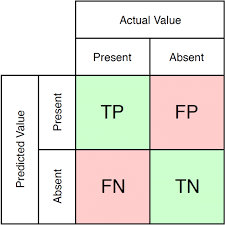

In [88]:
from datetime import date
from datetime import datetime


In [90]:
model_type_name="28_embed"

In [91]:
# SAVE MODEL
#  pls creatae a folder named model_saved if not there
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y %H_%M_%S")
PATH_to_save_model="model_saved/"+"model_"+dt_string+":"+model_type_name+".pt"
PATH_to_save_model="model_saved/model "+dt_string+".pt"
torch.save(model, PATH_to_save_model)

In [ ]:
# Model class must be defined somewhere
model2 = torch.load(PATH_to_save_model)
model2.eval()